<a href="https://colab.research.google.com/github/naoya5614/SIGNATE-Kaggle/blob/main/default_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
!nvidia-smi

Sun Oct 10 01:25:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [150]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb #LightGBM

In [119]:
# 読み込み
df = pd.read_csv('/content/drive/MyDrive/default_risk/train.csv')

# 重複部分の削除
df.drop_duplicates(inplace=True)

# 重複部分の削除の後に新しいインデックスを取得
df.reset_index(drop=True, inplace=True)

# 欠損値を削除
df = df.dropna()

# id列を削除
del df['id']

# 「years、year」を削除 ex.「3 years」→「3」
df["term"] = df["term"].str.replace('years', '')
df["employment_length"] = df["employment_length"].str.replace('years', '').str.replace('year', '')

# FullyPaidを0、ChargedOffを1に設定
df["loan_status"] = df["loan_status"].replace('FullyPaid', '0').replace('ChargedOff', '1')

df["term"] = df["term"].astype(int)
df["employment_length"] = df["employment_length"].astype(int)
df["loan_status"] = df["loan_status"].astype(int)

# データフレームの分離
col_categoric = ["grade", "purpose", "application_type", "loan_status"]
df_numeric = df.drop(col_categoric, axis=1)
df_categoric = df[col_categoric]

# df_categoric内の"loan_status"列と、df_numericの列を横結合する
df_tmp = pd.concat([df_categoric["loan_status"], df_numeric], axis=1)

In [120]:
df.head()

,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type,loan_status
0,1256.710800,5,10.603779,B1,5,debt_consolidation,680.431766,Individual,0
1,569.559607,3,17.305565,C5,3,house,713.063128,Individual,0
2,1118.838050,3,14.041342,C3,2,debt_consolidation,696.137378,Individual,1
3,610.721728,3,13.048348,C2,5,medical,656.373090,Individual,0
4,1180.026840,3,11.384862,B3,10,debt_consolidation,657.211233,Individual,0


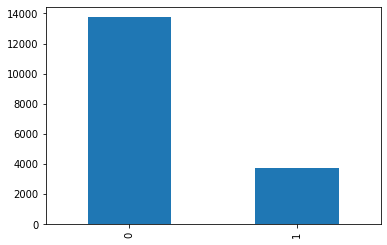

In [121]:
# データ数を取得
counts_loan_status = df["loan_status"].value_counts()

# 棒グラフの作成
counts_loan_status.plot(kind='bar')

# グラフの表示
plt.show()

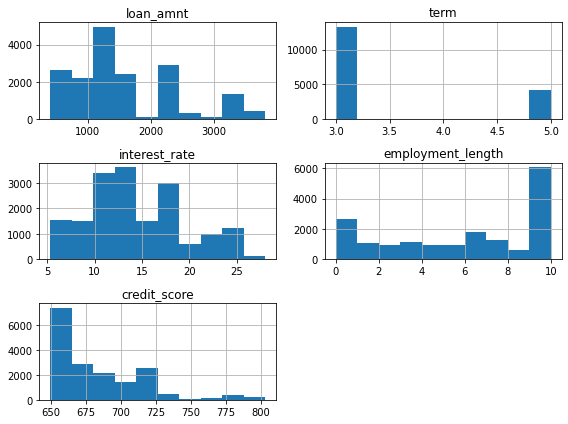

In [122]:
df_numeric.hist(figsize=(8, 6)) # df_numericは前処理で定義

# ラベルが重ならないように調整
plt.tight_layout()

# グラフの表示
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

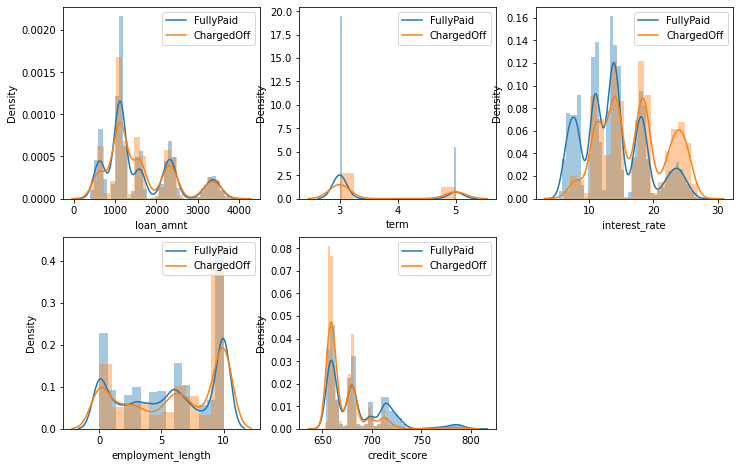

In [123]:
plt.figure(figsize=(12, 12))

for ncol, colname in enumerate(df_numeric.columns):
    plt.subplot(3, 3, ncol+1) # plt.subplot(縦のプロット数, 横のプロット数, プロット番号)
    sns.distplot(df_tmp.query("loan_status==0")[colname])
    sns.distplot(df_tmp.query("loan_status==1")[colname]) # 重ねる
    plt.legend(labels=["FullyPaid", "ChargedOff"], loc='upper right') # 凡例

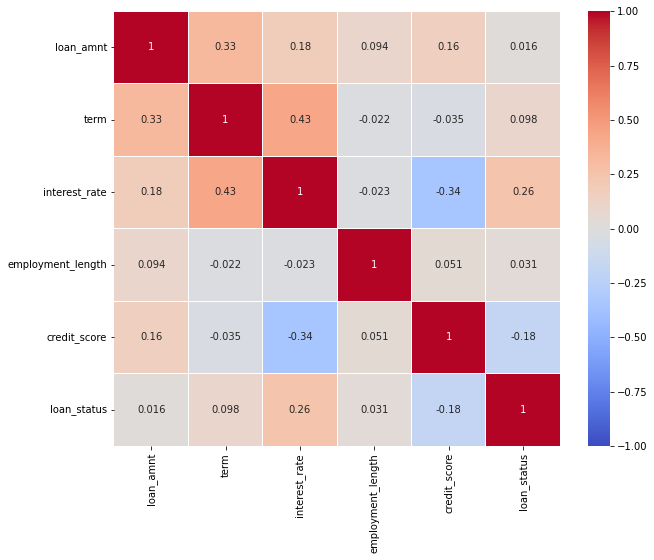

In [124]:
# グラフの整形
plt.figure(figsize=(10, 8))

# ヒートマップの作成
sns.heatmap(df.corr(), vmin=-1.0, vmax=1.0, annot=True,
            cmap='coolwarm', linewidths=0.1) # corr関数で相関関数を算出

In [125]:
# ダミー変数化
df = pd.get_dummies(
    df, columns=["grade", "purpose", "application_type"])

# 目的変数のデータフレーム
y = df["loan_status"]
# 説明変数のデータフレーム
X = df.drop(["loan_status"], axis=1)

# データの分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0)

In [126]:
# モデルの初期化
lr = LogisticRegression()

# モデルの学習
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [127]:
# 混同行列の作成
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# 混同行列をデータフレーム化
df_cm = pd.DataFrame(np.rot90(cm, 2), index=["実際のChargedOff", "実際のFullyPaid"], columns=["ChargedOffの予測", "FullyPaidの予測"])
print(df_cm)

# F1 Scoreの算出
f1 = f1_score(y_test, y_pred)
print(f1)

               ChargedOffの予測  FullyPaidの予測
実際のChargedOff            226          1289
実際のFullyPaid             165          5320
0.23714585519412382


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20104 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 20104 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 28204 missing from current font.
  font.set_text

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

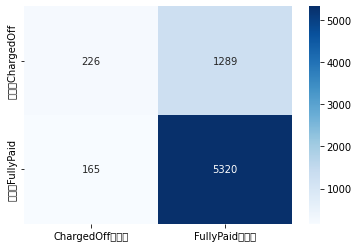

In [128]:
# heatmapによる混同行列の可視化
sns.heatmap(df_cm, annot=True, fmt="2g", cmap='Blues')
plt.yticks(va='center')

In [129]:
# 初期化
sampler = RandomUnderSampler(random_state=42)

# ダウンサンプリングの適用
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

# 返ってきたBoolを数値に変換
df["loan_status"] = df["loan_status"].replace(True, 0).replace(False, 1)
df["loan_status"] = df["loan_status"].astype(int)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [130]:
# 学習
lr = LogisticRegression()
lr.fit(X_resampled, y_resampled)

# 予測
y_pred = lr.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [131]:
df_cm = pd.DataFrame(np.rot90(cm, 2), index=["実際のChargedOff", "実際のFullyPaid"], columns=["ChargedOffの予測", "FullyPaidの予測"])
print(df_cm)

f1 = f1_score(y_test, y_pred)
print(f1)

               ChargedOffの予測  FullyPaidの予測
実際のChargedOff            226          1289
実際のFullyPaid             165          5320
0.4508215690812312


In [182]:
# 学習に使用するデータを設定
lgb_train = lgb.Dataset(X_resampled, y_resampled)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary', # 目的 : 2値分類 
        'metric': {'auc'}, # 評価指標 : 誤り率(= 1-正答率) 
        #他には 'binary_logloss','auc'など
        'learning_rate': 0.05,
        'num_leaves': 50,
        'min_data_in_leaf': 1,
        'num_iteration': 1000, #1000回学習
        'verbose': 0
}

# モデルの学習
model = lgb.train(params, # パラメータ
            train_set=lgb_train, # トレーニングデータの指定
            valid_sets=lgb_eval, # 検証データの指定
            early_stopping_rounds=100 # 100回ごとに検証精度の改善を検討　→ 精度が改善しないなら学習を終了(過学習に陥るのを防ぐ)
               )

# テストデータの予測 (クラス1の予測確率(クラス1である確率)を返す)
y_pred_prob = model.predict(X_test)
# テストデータの予測
y_pred2 = np.where(y_pred_prob < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.697977
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.699883
[3]	valid_0's auc: 0.704461
[4]	valid_0's auc: 0.708062
[5]	valid_0's auc: 0.707552
[6]	valid_0's auc: 0.711258
[7]	valid_0's auc: 0.712451
[8]	valid_0's auc: 0.714204
[9]	valid_0's auc: 0.716573
[10]	valid_0's auc: 0.71644
[11]	valid_0's auc: 0.717725
[12]	valid_0's auc: 0.71879
[13]	valid_0's auc: 0.720453
[14]	valid_0's auc: 0.721118
[15]	valid_0's auc: 0.721702
[16]	valid_0's auc: 0.721435
[17]	valid_0's auc: 0.722399
[18]	valid_0's auc: 0.722729
[19]	valid_0's auc: 0.721822
[20]	valid_0's auc: 0.721103
[21]	valid_0's auc: 0.721806
[22]	valid_0's auc: 0.722253
[23]	valid_0's auc: 0.722557
[24]	valid_0's auc: 0.722574
[25]	valid_0's auc: 0.722925
[26]	valid_0's auc: 0.723281
[27]	valid_0's auc: 0.723558
[28]	valid_0's auc: 0.723129
[29]	valid_0's auc: 0.723802
[30]	valid_0's auc: 0.724393
[31]	valid_0's auc: 0.724642
[32]	valid_0's auc: 0.725006
[33]	valid_0's auc: 

In [183]:
f1_gbm = f1_score(y_test, y_pred2)
print(f1_gbm)

0.4594180704441041


In [132]:
# 読み込み
df1 = pd.read_csv('/content/drive/MyDrive/default_risk/test.csv')

In [133]:
df1.head()

,id,loan_amnt,term,interest_rate,grade,employment_length,purpose,credit_score,application_type
0,0,1742.228656,5 years,7.992879,A4,8 years,debt_consolidation,677.196371,Individual
1,1,630.300979,3 years,13.604302,D3,6 years,debt_consolidation,655.143270,Individual
2,2,1606.895116,5 years,24.674460,C5,10 years,credit_card,680.532978,Individual
3,3,1120.716185,3 years,13.407068,C1,1 year,credit_card,659.544561,Individual
4,4,688.615551,3 years,18.118501,C2,10 years,other,654.822203,Individual


In [140]:
# id列を削除
del df1['id']

# 「years、year」を削除 ex.「3 years」→「3」
df1["term"] = df1["term"].str.replace('years', '')
df1["employment_length"] = df1["employment_length"].str.replace(
    'years', '').str.replace(
    'year', '')

df1["term"] = df1["term"].astype(int)
df1["employment_length"] = df1["employment_length"].astype(int)

# データフレームの分離
col_categoric1 = ["grade", "purpose", "application_type"]
df_numeric1 = df1.drop(col_categoric1, axis=1)
df_categoric1 = df1[col_categoric1]

# ダミー変数化
df1 = pd.get_dummies(df1, columns=["grade", "purpose", "application_type"])

In [141]:
df1.head()

,loan_amnt,term,interest_rate,employment_length,credit_score,grade_A1,grade_A2,grade_A3,grade_A4,grade_A5,grade_B1,grade_B2,grade_B3,grade_B4,grade_B5,grade_C1,grade_C2,grade_C3,grade_C4,grade_C5,grade_D1,grade_D2,grade_D3,grade_D4,grade_D5,grade_E1,grade_E2,grade_E3,grade_E4,grade_E5,grade_F3,grade_F5,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_other,purpose_small_business,application_type_Individual,application_type_Joint App
0,1742.228656,5,7.992879,8,677.196371,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,630.300979,3,13.604302,6,655.143270,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,1606.895116,5,24.674460,10,680.532978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1120.716185,3,13.407068,1,659.544561,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,688.615551,3,18.118501,10,654.822203,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [147]:
# 予測
y_pred1 = lr.predict(df1)

In [148]:
sub = pd.read_csv('/content/drive/MyDrive/default_risk/submit.csv', encoding = 'UTF-8', names=['id', 'ans'])
sub['ans'] = list(map(int, y_pred1))
sub.to_csv("submit_03.csv", header=False, index=False)